### <span style="font-family: Century Gothic">Modelling and Testing (fMRI ADHD/Sex Classification)</span>

In [147]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import joblib


<span style="font-family: Century Gothic; font-size:15px">Load Dataset</span>

In [148]:
df = pd.read_csv('Cleaned_fMRI.csv')
df.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,00aIpNTbG5uh,0.047912,0.147614,0.035215,0.041143,0.070673,0.080293,0.063638,-0.016682,0.043650,...,-0.031380,0.032986,0.081980,0.093708,0.021903,0.029458,-0.016072,0.169368,1,0
1,00fV0OyyoLfw,-0.003560,0.131635,0.067454,0.073367,0.013845,0.198074,0.038971,-0.109366,-0.034447,...,0.038632,-0.042040,0.125651,0.127045,0.142448,0.051943,0.138729,0.168951,1,0
2,04X1eiS79T4B,-0.076074,0.162668,0.050365,0.035320,0.055263,0.047298,0.155932,0.012768,0.084281,...,0.013774,-0.057094,0.084471,0.075582,0.093687,0.091592,0.114817,0.157812,0,1
3,05ocQutkURd6,0.054913,0.160764,0.150480,0.113151,0.135581,0.118498,0.032319,-0.078683,-0.013995,...,-0.075685,-0.029209,0.087122,0.009254,0.114800,0.218728,0.090305,0.159943,0,1
4,06YUNBA9ZRLq,0.100683,0.103170,0.046506,0.127893,0.075231,0.019648,0.116546,0.035825,0.044905,...,-0.005693,-0.001515,0.166933,0.005170,0.005126,0.126259,-0.038223,0.181322,1,0


In [3]:
df.shape

(1213, 19903)

<span style="font-family: Century Gothic; font-size:15px">Checking the null values</span>

In [7]:
np.mean(df.isnull().sum())

np.float64(0.0)

<span style="font-family: Century Gothic; font-size:25px">Dataset Summary:</span>

<span style="font-family: Century Gothic; font-size:15px">`1213` samples with `19903` features. </span>

<span style="font-family: Century Gothic; font-size:15px"> No missing values, meaning the dataset is fully preprocessed. </span>

<span style="font-family: Century Gothic; font-size:25px"> Target Variables: </span>

<span style="font-family: Century Gothic; font-size:15px"> ADHD_Outcome `0 = No ADHD`, `1 = ADHD`</span>

<span style="font-family: Century Gothic; font-size:15px"> Sex_F `0 = Male`, `1 = Female`</span>

In [5]:
df_model = df.copy()

# <span style="font-family: Century Gothic"> fMRI Modelling </span>

In [149]:
# Drop participant ID, extract labels
X = df_model.drop(columns=['participant_id', 'ADHD_Outcome', 'Sex_F']).values
y_adhd = df_model['ADHD_Outcome'].values
y_sex = df_model['Sex_F'].values

In [8]:
# Train/Test Split
X_train_adhd, X_test_adhd, y_train_adhd, y_test_adhd = train_test_split(
    X, 
    y_adhd, 
    test_size=0.2, 
    stratify=y_adhd, 
    random_state=42
)

X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(
    X, 
    y_sex, 
    test_size=0.2, 
    stratify=y_sex, 
    random_state=42
)

# <span style="font-family: Century Gothic; font-size:15px"> Normalize Data </span>

In [9]:
scaler = StandardScaler()
X_train_adhd_scaled = scaler.fit_transform(X_train_adhd)
X_test_adhd_scaled = scaler.transform(X_test_adhd)
X_train_sex_scaled = scaler.fit_transform(X_train_sex)
X_test_sex_scaled = scaler.transform(X_test_sex)

# <span style="font-family: Century Gothic; font-size:15px"> Model Architecture </span>

In [140]:
# Define Dense Model Architecture
def create_model(input_dim, lr=0.001, dropout_rate=0.3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [108]:
# Checkpoint
adhd_ckpt = 'adhd_best_model.keras'
sex_ckpt = 'sex_best_model.keras'

# <span style="font-family: Century Gothic;"> ADHD Modelling </span>

In [ ]:
# Early Stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    
    tf.keras.callbacks.ModelCheckpoint(
        filepath=adhd_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

<span style="font-family: Century Gothic; font-size:15px"> Train ADHD Model </span>

In [141]:
# Train CNN for ADHD Classification
cnn_adhd = create_model(X_train_adhd_scaled.shape[1])

cnn_adhd.build()
cnn_adhd.summary()

c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │    10,189,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,320,897 (39.37 MB)

 Trainable params: 10,320,897 (39.37 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
history_adhd = cnn_adhd.fit(
    X_train_adhd_scaled, 
    y_train_adhd, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test_adhd_scaled, y_test_adhd),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6119 - loss: 0.8662 - val_accuracy: 0.5021 - val_loss: 0.8523
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9562 - loss: 0.1330 - val_accuracy: 0.5638 - val_loss: 0.9254
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9969 - loss: 0.0123 - val_accuracy: 0.5679 - val_loss: 1.0726
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9991 - loss: 0.0098 - val_accuracy: 0.5473 - val_loss: 1.0991
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9966 - loss: 0.0181 - val_accuracy: 0.5062 - val_loss: 1.1961
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9970 - loss: 0.0064 - val_accuracy: 0.5267 - val_loss: 1.1950


<span style="font-family: Century Gothic; font-size:15px"> Plot Accuracy Curve </span>

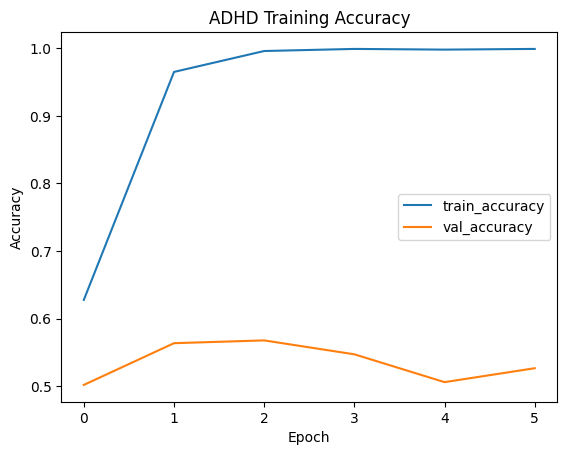

In [112]:
plt.plot(history_adhd.history['accuracy'], label='train_accuracy')
plt.plot(history_adhd.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ADHD Training Accuracy')
plt.show()

In [113]:
# Evaluate Model
y_pred_adhd = (
    cnn_adhd.predict(X_test_adhd_scaled) > 0.5
).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [114]:
print("\n🔹 ADHD Classification Report:\n", 
    classification_report(y_test_adhd, y_pred_adhd)
)
print("🔹 ADHD ROC AUC Score:", 
    roc_auc_score(
        y_test_adhd, 
        cnn_adhd.predict(X_test_adhd_scaled)
    )
)


🔹 ADHD Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.48      0.38        77
           1       0.68      0.51      0.58       166

    accuracy                           0.50       243
   macro avg       0.50      0.50      0.48       243
weighted avg       0.56      0.50      0.52       243

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
🔹 ADHD ROC AUC Score: 0.49421060866843997


In [115]:
pd.DataFrame(y_pred_adhd, columns=["ADHD_Prediction"]).to_csv("adhd_predictions.csv", index=False)

# <span style="font-family: Century Gothic;"> Sex Modelling </span>

In [142]:
callbacks[1] = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=sex_ckpt,
        monitor='val_loss',
        save_best_only=True
    )
]

In [143]:
# Train CNN for Sex Classification
cnn_sex = create_model(X_train_sex_scaled.shape[1])

cnn_sex.build()
cnn_sex.summary()

c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 512)            │    10,189,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,320,897 (39.37 MB)

 Trainable params: 10,320,897 (39.37 MB)

 Non-trainable params: 0 (0.00 B)

<span style="font-family: Century Gothic; font-size:15px"> Train Sex Model </span>

In [144]:
history_sex = cnn_sex.fit(
    X_train_sex_scaled, 
    y_train_sex, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test_adhd_scaled, y_test_sex),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.5903 - loss: 0.8505 - val_accuracy: 0.5226 - val_loss: 3.3364
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9701 - loss: 0.1031 - val_accuracy: 0.5062 - val_loss: 5.0527
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9903 - loss: 0.0556 - val_accuracy: 0.4938 - val_loss: 6.4802
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.4938 - val_loss: 6.8178
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 5.3581e-04 - val_accuracy: 0.4938 - val_loss: 7.0008
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9952 - loss: 0.0108 - val_accuracy: 0.5021 - val_loss: 7.6359


<span style="font-family: Century Gothic; font-size:15px"> Plot Accuracy Curve </span>

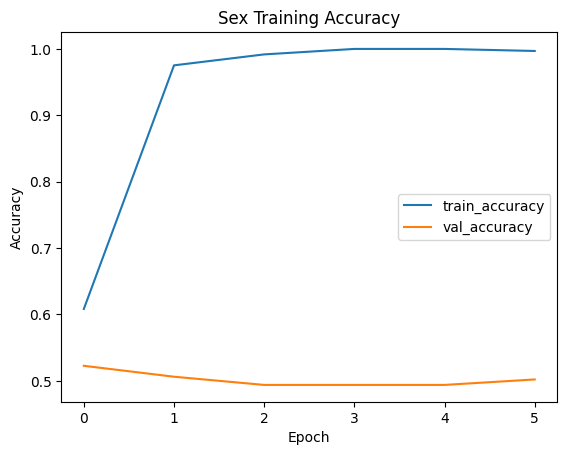

In [145]:
plt.plot(history_sex.history['accuracy'], label='train_accuracy')
plt.plot(history_sex.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Sex Training Accuracy')
plt.show()

In [120]:
y_pred_sex = (
    cnn_sex.predict(X_test_sex_scaled) > 0.5
).astype("int32")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [121]:
print("\n🔹 Sex Classification Report:\n", 
    classification_report(y_test_sex, y_pred_sex)
)
print("🔹 Sex ROC AUC Score:", 
    roc_auc_score(
        y_test_sex, 
        cnn_adhd.predict(X_test_sex_scaled)
    )
)


🔹 Sex Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76       160
           1       0.53      0.48      0.51        83

    accuracy                           0.68       243
   macro avg       0.64      0.63      0.63       243
weighted avg       0.67      0.68      0.67       243

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
🔹 Sex ROC AUC Score: 0.40120481927710844


In [122]:
pd.DataFrame(y_pred_sex, columns=["Sex_Prediction"]).to_csv("sex_predictions.csv", index=False)

# <span style="font-family: Century Gothic"> Hyperparameter Tuning for RandomForest

In [129]:
print("\n🔍 Hyperparameter Tuning - Random Forest (ADHD)...")
rfc = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(
    rfc, 
    param_grid, 
    cv=3, 
    scoring='f1', 
    verbose=1
)

rf_grid.fit(X_train_adhd_scaled, y_train_adhd)
rf_best = rf_grid.best_estimator_

y_pred = rf_best.predict(X_test_adhd_scaled)
y_proba = rf_best.predict_proba(X_test_adhd_scaled)[:, 1]

print('-----------------------------------------')
print(f'Best Params: {rf_grid.best_params_}')
print('-----------------------------------------')
print(classification_report(y_test_adhd, y_pred))
print('-----------------------------------------')
print(f'ROC AUC Score: {roc_auc_score(y_test_adhd, y_proba):.4f}')
print('-----------------------------------------')

joblib.dump(rf_best, "adhd_rf_model.pkl")


🔍 Hyperparameter Tuning - Random Forest (ADHD)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
-----------------------------------------
Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.68      1.00      0.81       166

    accuracy                           0.68       243
   macro avg       0.34      0.50      0.41       243
weighted avg       0.47      0.68      0.55       243

-----------------------------------------
ROC AUC Score: 0.5844
-----------------------------------------


c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\Essex\CE888\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

['adhd_rf_model.pkl']

# <span style="font-family: Century Gothic"> Hyperparameter Tuning for MLP

In [130]:
print("\n🔍 Hyperparameter Tuning - MLP (Sex)...")

mlp = MLPClassifier(max_iter=300)
mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}

mlp_grid = GridSearchCV(
    mlp, 
    mlp_params, 
    cv=3, 
    scoring='accuracy', 
    verbose=1
)

mlp_grid.fit(X_train_sex_scaled, y_train_sex)
mlp_best = mlp_grid.best_estimator_

y_pred = mlp_best.predict(X_test_sex_scaled)
y_proba = mlp_best.predict_proba(X_test_sex_scaled)[:, 1]

print('-----------------------------------------')
print(f'Best Params: {mlp_grid.best_params_}')
print('-----------------------------------------')
print(classification_report(y_test_sex, y_pred))
print('-----------------------------------------')
print(f'ROC AUC Score: {roc_auc_score(y_test_sex, y_proba):.4f}')
print('-----------------------------------------')

joblib.dump(mlp_best, "sex_mlp_model.pkl")


🔍 Hyperparameter Tuning - MLP (Sex)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
-----------------------------------------
Best Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
-----------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       160
           1       0.59      0.69      0.63        83

    accuracy                           0.73       243
   macro avg       0.70      0.72      0.71       243
weighted avg       0.74      0.73      0.73       243

-----------------------------------------
ROC AUC Score: 0.7792
-----------------------------------------


['sex_mlp_model.pkl']

# <span style="font-family: Century Gothic"> Model Comparison

In [132]:
models = {
    "CNN_ADHD": (cnn_adhd, X_test_adhd_scaled, y_test_adhd),
    "RF_ADHD": (rf_best, X_test_adhd_scaled, y_test_adhd),
    "CNN_Sex": (cnn_sex, X_test_sex_scaled, y_test_sex),
    "MLP_Sex": (mlp_best, X_test_sex_scaled, y_test_sex)
}

In [133]:
results = []
for name, (model, X_test, y_true) in models.items():
    if 'CNN' in name:
        y_pred = (model.predict(X_test) > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred)
    })

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [135]:
comparison_df = pd.DataFrame(results)

comparison_df.to_csv("model_comparison_table.csv", index=False)
comparison_df

,Model,Accuracy,F1 Score,ROC AUC
0,CNN_ADHD,0.502058,0.584192,0.496284
1,RF_ADHD,0.683128,0.811736,0.500000
2,CNN_Sex,0.679012,0.506329,0.631589
3,MLP_Sex,0.728395,0.633333,0.718373


<span style="font-family: Century Gothic"> 🧠 ADHD Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> Random Forest `RF_ADHD` significantly outperforms the `CNN` in terms of Accuracy `68.3%` and F1 Score `81.2%`, despite both models having low `ROC AUC`, indicating limited ability to rank predictions by confidence. </span>

<span style="font-family: Century Gothic; font-size: 15px">Conclusion: `RF` is more suitable for `ADHD` classification in this dataset. </span>

<span style="font-family: Century Gothic"> 🧬 Sex Classification: </span>

<span style="font-family: Century Gothic; font-size: 15px"> `MLP_Sex` shows the best performance across all metrics: Highest Accuracy `72.8%`, Highest F1 Score `63.3%`, Best ROC AUC `71.8%`. </span>

<span style="font-family: Century Gothic; font-size: 15px">Conclusion: `MLP` is more effective than `CNN` for classifying `SEX` from this `fMRI` data.</span>

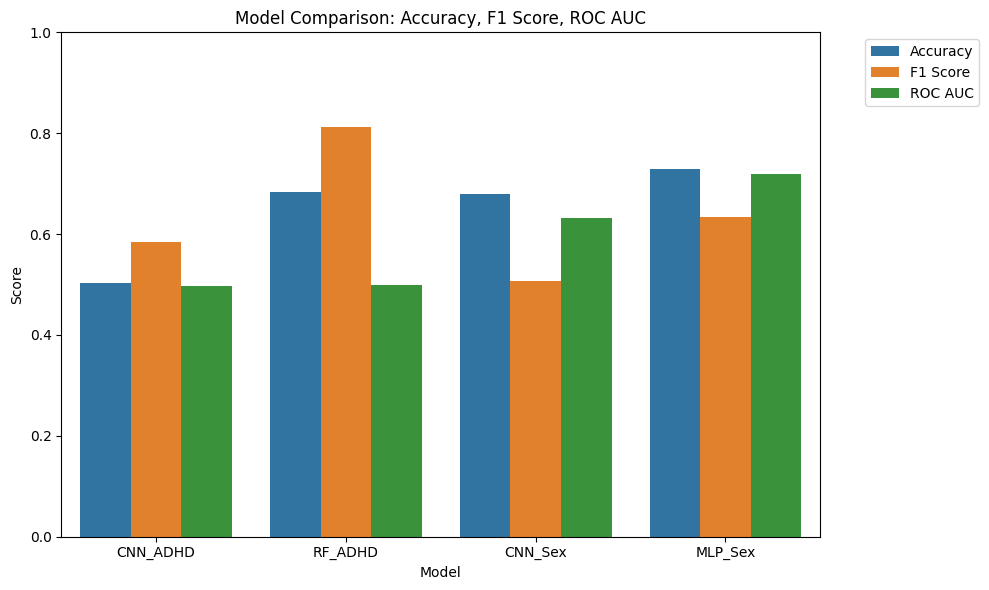

In [136]:
# Melt for easier seaborn plotting
comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_melted, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison: Accuracy, F1 Score, ROC AUC")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()